In [136]:
import nltk
import torch
import pandas as pd
import numpy as np
import torch.nn as nn
import torch.optim as optim
from torchviz import make_dot
import matplotlib.pyplot as plt
from nltk.util import ngrams,pad_sequence
from nltk.lm.preprocessing import pad_both_ends
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import classification_report
from sentence_transformers import SentenceTransformer
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [61]:
!pip install sentence_transformers

  Using cached sentence_transformers-2.2.2-py3-none-any.whl
  Using cached torchvision-0.15.2-cp39-cp39-win_amd64.whl (1.2 MB)


In [12]:
pip install nltk

Note: you may need to restart the kernel to use updated packages.


In [63]:
model_text = SentenceTransformer('all-MiniLM-L12-v2')

In [2]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Dell\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [124]:
!pip install torchviz

  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
     -------------------------------------- 47.0/47.0 kB 123.9 kB/s eta 0:00:00
  Created wheel for torchviz: filename=torchviz-0.0.2-py3-none-any.whl size=4131 sha256=2c95dddd1f7422f72d8fca3dc094248efc84e3878635db428863fb135d7b3622
  Stored in directory: c:\users\dell\appdata\local\pip\cache\wheels\29\65\6e\db2515eb1dc760fecd36b40d54df65c1e18534013f1c037e2e
Successfully built torchviz


In [2]:
sentiment_csv=pd.read_csv("sentiment.csv",index_col=0)
sentiment_csv.drop(['imgid','filename','successful','sentiment'],axis=1,inplace=True)

In [3]:
sentiment_csv.head(3)

,split,tokens,word_sentiment,raw
0,train,"['a', 'plate', 'of', 'delicious', 'food', 'inc...","[0.0, 0.0, 0.0, 1, 1, 0.0, 0.0, 0.0]",a plate of delicious food including French fries.
1,train,"['french', 'fries', 'are', 'not', 'a', 'health...","[0.0, 0.0, 0.0, 0.0, 0.0, 1, 1, 0.0, 0.0, 0.0,...",French fries are not a healthy food but it is ...
2,train,"['the', 'plate', 'has', 'one', 'of', 'my', 'fa...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1, 1, 0.0, 0.0,...","The plate has one of my favorite foods on it, ..."


In [4]:
Train=sentiment_csv[sentiment_csv['split']=='train']
Validate=sentiment_csv[sentiment_csv['split']=='val']
Test=sentiment_csv[sentiment_csv['split']=='test']

In [5]:
Train.drop('split',axis=1,inplace=True)
Validate.drop('split',axis=1,inplace=True)
Test.drop('split',axis=1,inplace=True)

C:\Users\Dell\AppData\Local\Temp\ipykernel_18584\1770475362.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Train.drop('split',axis=1,inplace=True)
C:\Users\Dell\AppData\Local\Temp\ipykernel_18584\1770475362.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Validate.drop('split',axis=1,inplace=True)
C:\Users\Dell\AppData\Local\Temp\ipykernel_18584\1770475362.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Test.drop('split',ax

In [6]:
Train.head(3)

,tokens,word_sentiment,raw
0,"['a', 'plate', 'of', 'delicious', 'food', 'inc...","[0.0, 0.0, 0.0, 1, 1, 0.0, 0.0, 0.0]",a plate of delicious food including French fries.
1,"['french', 'fries', 'are', 'not', 'a', 'health...","[0.0, 0.0, 0.0, 0.0, 0.0, 1, 1, 0.0, 0.0, 0.0,...",French fries are not a healthy food but it is ...
2,"['the', 'plate', 'has', 'one', 'of', 'my', 'fa...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1, 1, 0.0, 0.0,...","The plate has one of my favorite foods on it, ..."


In [7]:
Test.reset_index(drop=True,inplace=True)
Test.head(3)

,tokens,word_sentiment,raw
0,"['a', 'person', 'wearing', 'a', 'beautiful', '...","[0.0, 0.0, 0.0, 0.0, 1, 1, 0.0, 0.0, 0.0, 0.0,...",a person wearing a beautiful dress under an um...
1,"['a', 'person', 'with', 'a', 'beautiful', 'dre...","[0.0, 0.0, 0.0, 0.0, 1, 1, 0.0, 0.0, 0.0, 0.0,...",A person with a beautiful dress with an umbrel...
2,"['the', 'adorable', 'child', 'wears', 'a', 'pr...","[0.0, 1, 1, 0.0, 0.0, 1, 1, 0.0, 0.0, 0.0, 0.0...","The adorable child wears a pretty dress, that ..."


In [8]:
Validate.reset_index(drop=True,inplace=True)
Validate.head(3)

,tokens,word_sentiment,raw
0,"['a', 'nice', 'person', 'holds', 'a', 'flip', ...","[0.0, 1, 1, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]",A nice person holds a flip phone displaying th...
1,"['a', 'person', 'holding', 'a', 'cell', 'phone...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1, 1]",A person holding a cell phone in their good hand.
2,"['someones', 'right', 'hand', 'holding', 'up',...","[0.0, 1, 1, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",Someone's right hand holding up a flip phone i...


In [9]:
def get_unique_dict(dataframe_pass):
    
    TOKENS=dataframe_pass.tokens
    LABELS=dataframe_pass.word_sentiment
    sentence_label={}
    for i,j in zip(TOKENS,LABELS):
            n_g=list(ngrams(pad_both_ends(eval(i), n=2),n=3))          # for list input
            label = j.strip("[]") 
            label= [int(float(x)) for x in label.split(", ")]
            for z,x in zip(n_g,label):
                if z not in sentence_label.keys():
                        sentence_label[z]=x
    return sentence_label

In [11]:
Train_dict=get_unique_dict(Train)
Val_dict=get_unique_dict(Validate)
Test_dict=get_unique_dict(Test)

In [12]:
print("Train : ",len(Train_dict))
print("Val : ",len(Val_dict))
print("Test : ",len(Test_dict))

Train :  31293
Val :  7962
Test :  24990


In [43]:
temp_train= [(key, value) for key, value in Train_dict.items()]
temp_val=[(key, value) for key, value in Val_dict.items()]
temp_test=[(key, value) for key, value in Test_dict.items()]

In [44]:
new_train=pd.DataFrame(temp_train,columns=['trigrams','sentiment'])
new_val=pd.DataFrame(temp_val,columns=['trigrams','sentiment'])
new_test=pd.DataFrame(temp_test,columns=['trigrams','sentiment'])

In [46]:
new_train.head(3)

,trigrams,sentiment
0,"(<s>, a, plate)",0
1,"(a, plate, of)",0
2,"(plate, of, delicious)",0


In [47]:
new_val.head(3)

,trigrams,sentiment
0,"(<s>, a, nice)",0
1,"(a, nice, person)",1
2,"(nice, person, holds)",1


In [48]:
new_test.head(3)

,trigrams,sentiment
0,"(<s>, a, person)",0
1,"(a, person, wearing)",0
2,"(person, wearing, a)",0


In [75]:
class Personal_Text_Dataset(Dataset):
    def __init__(self, frame ):
        self.dataframe=frame
    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        tuple_value,label= self.dataframe.iloc[idx]
        tuple_value=" ".join(tuple_value)
        sentence_embedding=torch.tensor(model_text.encode(tuple_value))
        label_tensor=torch.tensor(label,dtype=torch.long)

        return sentence_embedding,label_tensor

In [82]:
Train_data=Personal_Text_Dataset(new_train)
Val_data=Personal_Text_Dataset(new_val)
Test_data=Personal_Text_Dataset(new_test)

In [93]:
train_loader=DataLoader(dataset=Train_data,batch_size=64,shuffle=True)
validate_loader=DataLoader(dataset=Val_data,batch_size=64,shuffle=False)
test_loader=DataLoader(dataset=Test_data,batch_size=64,shuffle=False)

In [97]:
class Personal_Text_Classifier(nn.Module):
    def __init__(self):
        super(Personal_Text_Classifier, self).__init__()
        self.relu = nn.ReLU()
        self.sig=nn.Sigmoid()

        

        self.text_l1=nn.Linear(384,150)
        self.text_l2=nn.Linear(150,90)
        self.text_l3=nn.Linear(90,40)
        self.text_l4=nn.Linear(40,10)

        self.output=nn.Linear(10,1)

              
    def forward(self, y):

        y=self.text_l1(y)
        y=self.relu(y)


        y=self.text_l2(y)
        y=self.relu(y)

        y=self.text_l3(y)
        y=self.relu(y)
        
        y=self.text_l4(y)
        y=self.relu(y)
        
        answer=self.output(y)
        answer=self.sig(answer)
        
        return answer

In [106]:
Model= Personal_Text_Classifier()

criterion = nn.BCELoss()
optimizer = optim.Adam(Model.parameters(), lr=0.001)

In [107]:
epochs=2
n_batch_loss=[]
for epoch in range(epochs):
    running_loss = 0.0
    total_train = 0
    correct_train = 0
    model.train()
    for i, batch in enumerate(train_loader):
        text,labels = batch  
        
        optimizer.zero_grad()

        outputs = Model(text)

        labels = labels.unsqueeze(1)
        labels=labels.float()

        loss = criterion(outputs,labels)
        

        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        outputs=torch.round(outputs)

        correct_train=correct_train + torch.eq(outputs,labels).sum()
        total_train=total_train+labels.size(0)
        if i%50==0:
              print(i+1," Batch loss : ",round(loss.item(),3))
              n_batch_loss.append(round(loss.item(),3))
    print("\nTrain loss : ",round(running_loss/len(train_loader),3))
    print("Train accuracy : ",round(correct_train.item()/total_train*100,1),"\n")
    model.eval()
    with torch.no_grad():
      running_loss=0
      correct_train=0
      total_train=0
      for i,batch in enumerate(validate_loader):
          text,labels=batch

          outputs = Model(text)
            
          labels = labels.unsqueeze(1)
          labels=labels.float()
            
          loss=criterion(outputs,labels)
        
          running_loss += loss.item()
            
          outputs=torch.round(outputs)
          total_train+=labels.size(0)
            
            
          correct_train=correct_train + torch.eq(outputs,labels).sum()
        
        
    print("\nVal loss : ",round(running_loss/len(train_loader),3))
    print("Val accuracy : ",round(correct_train.item()/total_train*100,1),"\n")
            

1  Batch loss :  0.766
51  Batch loss :  0.437
101  Batch loss :  0.343
151  Batch loss :  0.227
201  Batch loss :  0.299
251  Batch loss :  0.366
301  Batch loss :  0.175
351  Batch loss :  0.137
401  Batch loss :  0.243
451  Batch loss :  0.166

Train loss :  0.273
Train accuracy :  85.9 


Val loss :  0.042
Val accuracy :  94.0 

1  Batch loss :  0.109
51  Batch loss :  0.181
101  Batch loss :  0.13
151  Batch loss :  0.102
201  Batch loss :  0.041
251  Batch loss :  0.058
301  Batch loss :  0.082
351  Batch loss :  0.077
401  Batch loss :  0.227
451  Batch loss :  0.13

Train loss :  0.15
Train accuracy :  94.7 


Val loss :  0.035
Val accuracy :  95.5 



In [135]:
predicted_labels=[]
true_labels=[]
model.eval()
with torch.no_grad():
  running_loss=0
  correct_train=0
  total_train=0
  for i,batch in enumerate(test_loader):
      text,labels=batch

      outputs = Model(text)
        
      labels = labels.unsqueeze(1)
      labels=labels.float()
        
      loss=criterion(outputs,labels)
      running_loss += loss.item()
     
      total_train+=labels.size(0)
      outputs=torch.round(outputs)
      
      predicted_labels.append(outputs)
      true_labels.append(labels)
      correct_train=correct_train + torch.eq(outputs,labels).sum()
      if i%50==0:
              print(i+1," Batch loss : ",round(loss.item(),3))
print("\nTest loss : ",round(running_loss/len(train_loader),3))
print("Test accuracy : ",round(correct_train.item()/total_train*100,1),"\n")

1  Batch loss :  0.098
51  Batch loss :  0.098
101  Batch loss :  0.109
151  Batch loss :  0.106
201  Batch loss :  0.19
251  Batch loss :  0.286
301  Batch loss :  0.07
351  Batch loss :  0.13

Test loss :  0.114
Test accuracy :  95.2 



In [137]:
answer=predicted_labels[0]
for i in predicted_labels[1:]:
  answer=torch.cat([answer,i])

In [138]:
true=true_labels[0]
for i in true_labels[1:]:
  true=torch.cat([true,i])

In [139]:
answer=answer.squeeze(1)
true=true.squeeze(1)

In [140]:
print(classification_report(true,answer))

              precision    recall  f1-score   support

         0.0       0.97      0.97      0.97     20165
         1.0       0.88      0.87      0.88      4825

    accuracy                           0.95     24990
   macro avg       0.92      0.92      0.92     24990
weighted avg       0.95      0.95      0.95     24990



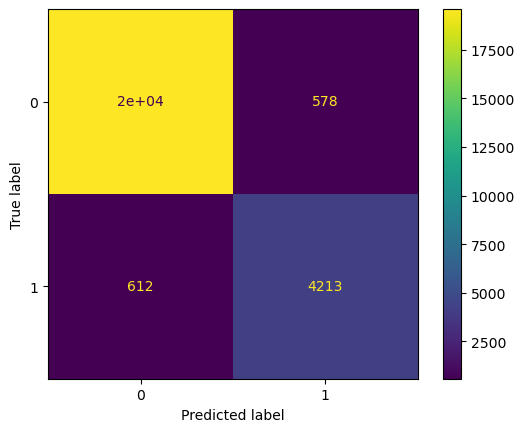

In [142]:
matrix=confusion_matrix(true,answer,labels=[0,1])
show=ConfusionMatrixDisplay(confusion_matrix=matrix,display_labels=[0,1])
show.plot()
plt.show()

In [116]:
torch.save(model.state_dict(),"Text_Classifier.pt")

In [117]:
model_1=Text_Image_Classifier()

In [118]:
model_1.load_state_dict(torch.load('Text_Classifier.pt'))

<All keys matched successfully>